<a href="https://colab.research.google.com/github/sanbasso/coderino/blob/master/DeepseekTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive (if saving files)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Load data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)

# Explore
print(df.head())  # First 5 rows
print(df.info())  # Columns and data types
print(df.describe())  # Statistical summary

  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...   209322  209340  209358  209362   
1        0        0        0        0  ...   334391  334408  334408  334427   
2        0        0        0        0  ...   271441  271448  271463  271469   
3        0        0        0        0  ...    47866   47875   47875   47875   
4        0        0        0        0  ...   105255  105277  105277  105277   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0  209369  209390  209406  2

In [13]:
# Drop unnecessary columns
df_clean = df.drop(columns=['Lat', 'Long', 'Province/State'])

# Melt data to convert dates into rows
df_melted = df_clean.melt(id_vars=['Country/Region'], var_name='Date', value_name='Cases')
df_melted['Date'] = pd.to_datetime(df_melted['Date'])

# Group by country and date
df_grouped = df_melted.groupby(['Country/Region', 'Date']).sum().reset_index()

<ipython-input-13-5a7c33aad49c>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_melted['Date'] = pd.to_datetime(df_melted['Date'])


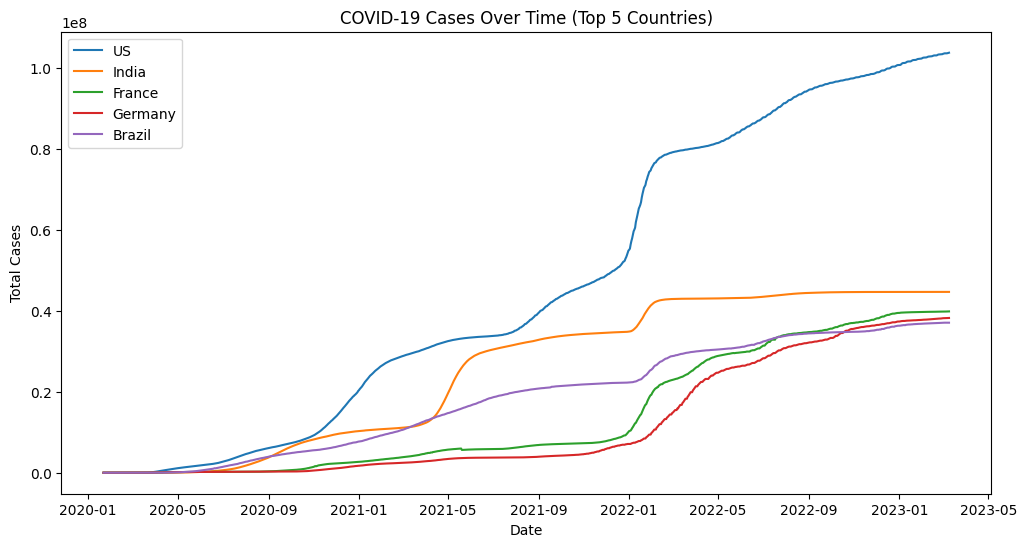

In [14]:
top_countries = df_grouped.groupby('Country/Region')['Cases'].max().nlargest(5).index
plt.figure(figsize=(12, 6))
for country in top_countries:
    data = df_grouped[df_grouped['Country/Region'] == country]
    plt.plot(data['Date'], data['Cases'], label=country)
plt.title('COVID-19 Cases Over Time (Top 5 Countries)')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.show()

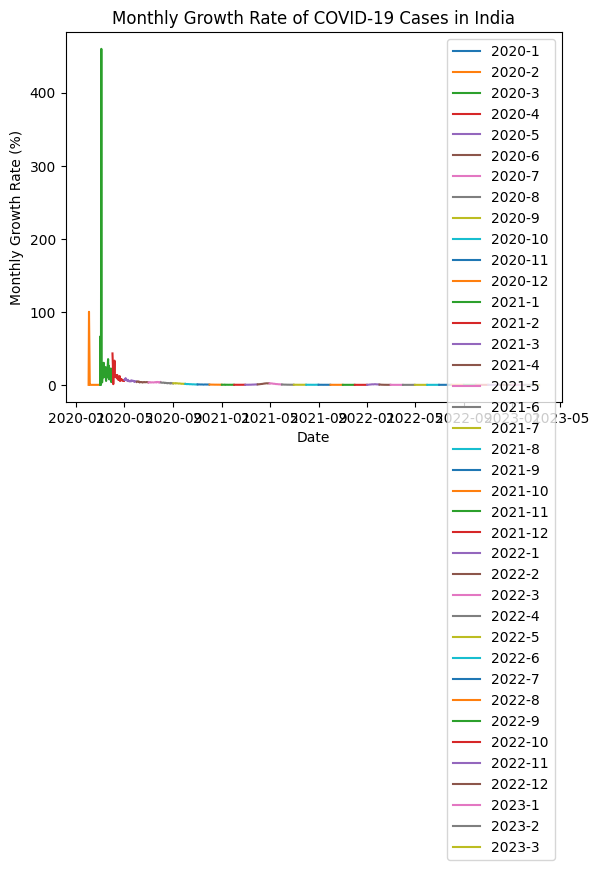

In [18]:
# Filter for a specific country (e.g., India)
df_india = df_grouped[df_grouped['Country/Region'] == 'India'].copy()
df_india['Monthly Growth'] = df_india['Cases'].pct_change() * 100  # Percentage growth
for month in df_india['Date'].dt.to_period('M').unique():
    month_data = df_india[df_india['Date'].dt.to_period('M') == month]
    plt.plot(month_data['Date'], month_data['Monthly Growth'], label=f'{month.year}-{month.month}')
plt.title('Monthly Growth Rate of COVID-19 Cases in India')
plt.xlabel('Date')
plt.ylabel('Monthly Growth Rate (%)')
plt.legend()
plt.show()
#

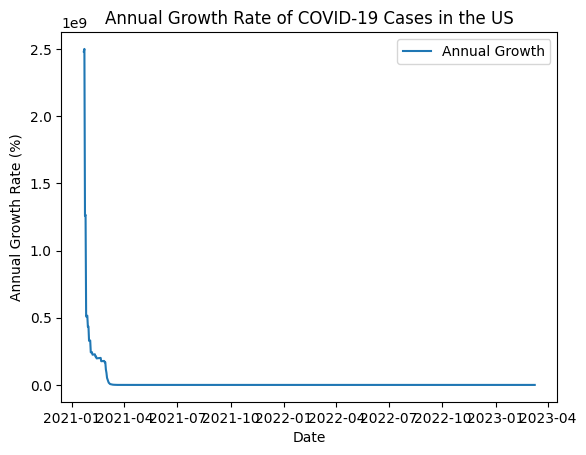

In [22]:
df_us = df_grouped[df_grouped['Country/Region'] == 'US'].copy()
df_us['Annual Growth'] = df_us['Cases'].pct_change(periods=365) * 100  # Percentage growth over 365 days

plt.plot(df_us['Date'], df_us['Annual Growth'], label='Annual Growth')
plt.title('Annual Growth Rate of COVID-19 Cases in the US')
plt.xlabel('Date')
plt.ylabel('Annual Growth Rate (%)')
plt.legend()
plt.show()

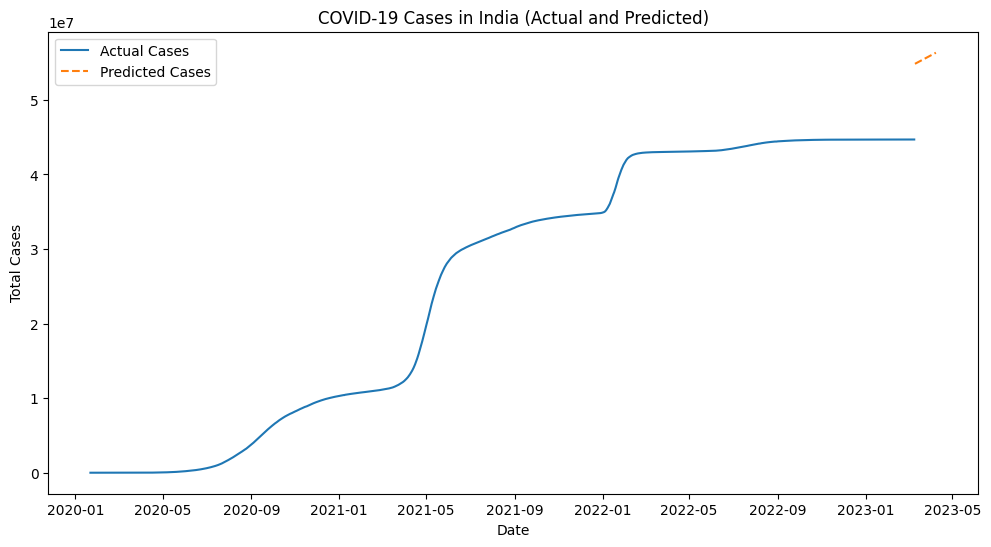

In [26]:
from sklearn.linear_model import LinearRegression

# Convert dates to numeric values
df_india['Days'] = (df_india['Date'] - df_india['Date'].min()).dt.days

# Train model
X = df_india[['Days']]  # Keep X as a DataFrame with column name 'Days'
y = df_india['Cases']
model = LinearRegression()
model.fit(X, y)

# Predict next 30 days
future_days = pd.DataFrame({'Days': np.arange(df_india['Days'].max() + 1, df_india['Days'].max() + 31)})  # Create DataFrame for prediction
future_cases = model.predict(future_days)

# Create future dates
future_dates = pd.date_range(start=df_india['Date'].max() + pd.Timedelta(days=1), periods=30)

# Plot actual and predicted data
plt.figure(figsize=(12, 6))
plt.plot(df_india['Date'], df_india['Cases'], label='Actual Cases')
plt.plot(future_dates, future_cases, label='Predicted Cases', linestyle='--')
plt.title('COVID-19 Cases in India (Actual and Predicted)')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.show()


#India’s COVID-19 cases grew exponentially in April 2021, with a monthly growth rate of 120%.
#The US and India had the highest total cases, but growth rates varied based on lockdown policies.